# Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import string
import glob
import re
import itertools
import hashlib
from collections import Counter

import scipy as sp
import numpy as np
import pandas as pd

import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=False, world_readable=True, theme='pearl')
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Files

In [3]:
# get datadir
import platform
uname = platform.uname()[0]
if uname == 'Linux':
    datadir = '/home/kcavagnolo/ml_fun/telstra/data/'
elif uname == 'Darwin':
    datadir = '/Users/cavagnolo/ml_fun/telstra/data/'
else:
    raise OSError("Unknown system: " + str(uname))

# get files
files = sorted(glob.glob(datadir + '*.csv'))
hdf_file = datadir + 'features.h5'

# reopen hdf store
hdf = pd.HDFStore(hdf_file)

# reload df's
print hdf
df_test = hdf['df_test']
df_train = hdf['df_train']
df_all = hdf['df_all']
hdf.close()

# reset indexing
df_train = df_train.sort_values(by='id').reset_index(drop=True)
df_test = df_test.sort_values(by='id').reset_index(drop=True)
df_all = df_all.sort_values(by='id').reset_index(drop=True)

# cols to drop
attribute_drop = ['fault_severity', 'id', 'location', 'is_train']

# col prefixes
attributes = ['event_', 'resource_', 'severity_', 'log_feature_']

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/cavagnolo/ml_fun/telstra/data/features.h5
/df_adatree            frame        (shape->[15,6])     
/df_all                frame        (shape->[18552,458])
/df_culled             frame        (shape->[17983,266])
/df_known              frame        (shape->[569,4])    
/df_test               frame        (shape->[11171,457])
/df_train              frame        (shape->[7381,458]) 


In [11]:
# go through each file and tell me what's in it
for f in files:
    df = pd.read_csv(f)
    cols = df.columns.tolist()
    obs = df.shape[0]
    print '{:15} {:s}'.format('Filename:', f)
    print '{:15} {:d}'.format('Observations:', obs)
    for c in cols:
        uflag = ""
        nflag = ""
        uni = len(pd.unique(df[c].ravel()))
        nulls = np.count_nonzero(df[c].isnull())
        if obs != uni:
            uflag = '*MULTIPLE VALS PER KEY*'
        if nulls >0 :
            nflag = '*NULLS IN COL*'
        print '{:15} {:d} {:20} {:20}'.format(c, uni, uflag, nflag)
    print '\n'

Filename:       /home/kcavagnolo/ml_fun/telstra/data/event_type.csv
Observations:   31170
id              18552 *MULTIPLE VALS PER KEY*                     
event_type      53 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/log_feature.csv
Observations:   58671
id              18552 *MULTIPLE VALS PER KEY*                     
log_feature     386 *MULTIPLE VALS PER KEY*                     
volume          341 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/resource_type.csv
Observations:   21076
id              18552 *MULTIPLE VALS PER KEY*                     
resource_type   10 *MULTIPLE VALS PER KEY*                     


Filename:       /home/kcavagnolo/ml_fun/telstra/data/sample_submission.csv
Observations:   11171
id              11171                                          
predict_0       1 *MULTIPLE VALS PER KEY*                     
predict_1       1 *MULTIPLE VALS PER 

* Column names look fine, don't need to clean those
* No nulls, hooray
* Looks like each ID has only one severity type and multiple event types| log features| resource types:

For example, in the training set, consider ID 10005:

|id| item | code | sev/vol
|:-|:-|:-:|:-:
|10005 | location |802 | 0
|10005|severity_type |1|
|10005|event_type |11|
|10005|event_type |13|
|10005|event_type |14|
|10005|log_feature| 345|1
|10005|log_feature| 54|1
|10005|resource_type |4|
|10005|resource_type |6|
|10005|resource_type |8|

Transposing would be

|id|loc|sev|evt|fea|res
|-|
|10005|{802:0}|1|[11,13,14]|{54:1,345:1}|[4,6,8]

For a single id, the coding can't be a list, so one hot encode every type? How many are we talking?
* 53 event types (binary)
* 386 log features (continuous)
* 10 resource types (binary)

That's 449 features. Regardless, need to join all this data together. It's all categorical data (code_n is y/n), except for the log features which has a volume.

# Basics

* <s>Replace missing values</s>
* <s>Remove duplicates</s>
* <s>One-Hot encode categorical features</s>
* Find outliers and explain
* <s>Scale</s>
* <s>Standardize</s>

## Raw

In [5]:
files

['/Users/cavagnolo/ml_fun/telstra/data/event_type.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/log_feature.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/resource_type.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/sample_submission.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/severity_type.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test_dataset.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test_dl.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test_ksmod.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test_master.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/test_merge.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train_dataset.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train_dl.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train_ksmod.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train_master.csv',
 '/Users/cavagnolo/ml_fun/telstra/data/train_merge.csv']

In [49]:
# build train df
df = pd.read_csv(datadir + 'train.csv', index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_train = df.copy()

# build test df
df = pd.read_csv(datadir + 'test.csv', index_col=0)
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
df_test = df.copy()

print df_train.shape
print df_test.shape

(7381, 2)
(11171, 1)


In [68]:
sev = pd.read_csv(datadir + 'severity_type.csv', index_col='id')
sev = sev.join(df_train, rsuffix='train')
sev = sev.join(df_test, rsuffix='test')
sev.severity_type = sev.severity_type.map(lambda x: re.sub("[^0-9]", "", x))

In [71]:
sev.head(50)

,severity_type,location,fault_severity,locationtest
id,,,,
6597,2,NaN,NaN,1
8011,2,1,0,NaN
2597,2,NaN,NaN,1
5022,1,NaN,NaN,1
6852,1,NaN,NaN,1
5611,2,NaN,NaN,1
14838,1,NaN,NaN,1
2588,1,1,0,NaN
4848,1,1,0,NaN


In [85]:
sev['sev_loc_order'] = np.zeros(len(sev))

In [88]:
for loc in df_train.location.unique():
    df = sev[(sev.location == loc) | (sev.locationtest == loc)]
    sev['sev_loc_order'][(sev.location == loc) | (sev.locationtest == loc)] = range(0,(len(df)))

In [89]:
sev.head(100)

,severity_type,location,fault_severity,locationtest,sev_loc_order
id,,,,,
6597,2,NaN,NaN,1,0
8011,2,1,0,NaN,1
2597,2,NaN,NaN,1,2
5022,1,NaN,NaN,1,3
6852,1,NaN,NaN,1,4
5611,2,NaN,NaN,1,5
14838,1,NaN,NaN,1,6
2588,1,1,0,NaN,7
4848,1,1,0,NaN,8


## Scaling

In [ ]:
# read raw volumes
df = pd.read_csv(files[1])

# cleanup col names
for c in df.columns:
    if df[c].dtypes == 'object':
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
        
# re-org by id        
vols = df.pivot(index='id', columns='log_feature', values='volume').fillna(0)
cnames = ['log_feature_'+str(x) for x in vols.columns]

# scale or min-max
vols_scl = vols.apply(lambda x: preprocessing.MinMaxScaler().fit_transform(x))
vols_scl.columns = cnames

## One hot and join

In [ ]:
# add categorical event_type, resource_type, severity_type
nfiles = [files[0], files[2], files[3]]
for f in nfiles:
    df = pd.read_csv(f, index_col=0)
    for c in df.columns:
        df[c] = df[c].map(lambda x: re.sub("[^0-9]", "", x))
    dfv = pd.get_dummies(df).groupby(df.index).sum()
    df_train = df_train.join(dfv)
    df_test = df_test.join(dfv)

In [ ]:
# join volumes
df_train = df_train.join(vols_scl)
df_test = df_test.join(vols_scl)

In [ ]:
# gut check the 10005 entry from above
junk = df_train.T
x = junk.loc[:, 10005] > 0
x[x].index

# Save

In [ ]:
# merge df's
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train['is_train'] = True
df_test['is_train'] = False
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=False)
a = df_train.shape[0]
b = df_test.shape[0]
c = df_all.shape[0]
assert(a + b == c, "DF's are not summing correctly")

In [ ]:
# save to hdf5 for easier loading later
call(["rm", "-rf", hdf_file])
hdf = pd.HDFStore(hdf_file)
hdf.put('df_test', df_test)
hdf.put('df_train', df_train)
hdf.put('df_all', df_all)
hdf.close()

# Attribute Summaries

## Relations

In [4]:
df_all[['id','location', 'fault_severity']].scatter_matrix()

The draw time for this plot will be slow for all clients.


Looks like locations 100-500 don't produce any fault_sev==2 events. This could be useful to a model, so maybe don't throw out location as I had previously.

In [110]:
df_all.groupby(['location', 'fault_severity']).size()

location  fault_severity
1         0                 14
          1                  8
          2                  2
10        0                  1
100       0                 13
          1                  2
1000      0                  3
1002      0                  1
1005      0                  1
1006      0                  3
1007      0                 16
          1                  3
1008      0                 34
          1                 21
          2                 16
1009      0                  4
101       0                  1
1010      0                 13
          1                  6
1011      0                  1
          1                  7
          2                  1
1013      0                  1
1014      0                  5
          1                  6
          2                  1
1015      0                  5
          1                  6
1016      1                  2
          2                  1
                            ..
979       1   

## Histograms

In [3]:
# build axes
mpl_fig = plt.figure()
ax1 = mpl_fig.add_subplot(411)
ax2 = mpl_fig.add_subplot(412)
ax3 = mpl_fig.add_subplot(413)
ax4 = mpl_fig.add_subplot(414)
axs = [ax1, ax2, ax3, ax4]

# iterate over each
for cond in [True, False]:
    for i, b in enumerate(attributes):
        y = df_all[(df_all.is_train == cond)].filter(regex=b).apply(pd.value_counts).fillna(0).T[0]
        y = 100.*(1.0-(y/df_all[(df_all.is_train == cond)].shape[0]))
        x = range(1, len(y)+1)
        axs[i].bar(x, y, label=attributes[i])
        axs[i].set_ylabel(attributes[i])
py.iplot_mpl(mpl_fig, strip_style=True)

Distributions looks similar, so train will cv w/ test. Any structure in sequence of ID's?

## Sequencing

In [35]:
df = df_all[['id', 'fault_severity', 'location']].set_index('id')
df.iplot(subplots=True, shape=(2,1), shared_xaxes=True)

The draw time for this plot will be slow for clients without much RAM.


Both look like noise to me, gonna leave it for now. What about correlations among the various codes?

## Correlations

In [4]:
strongly_correlated = []
corr_thresh = 0.12

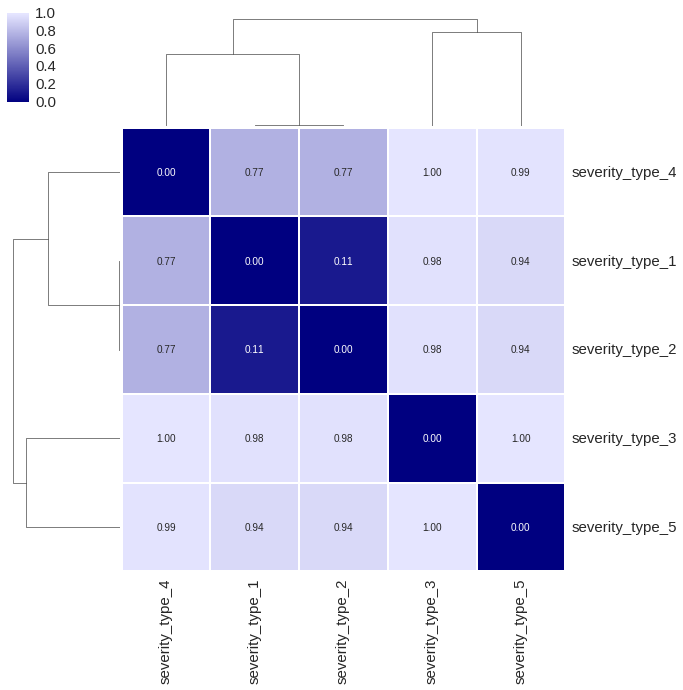

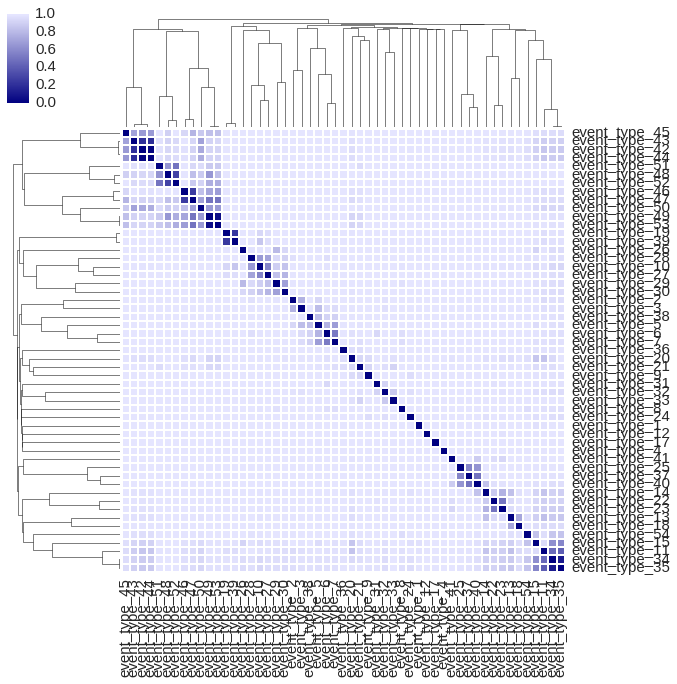

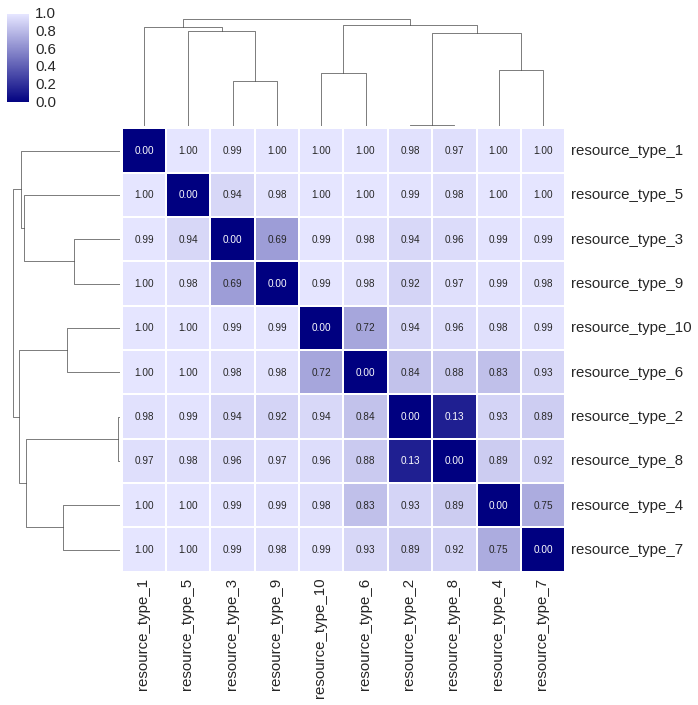

In [5]:
a = ['severity_type', 'event_type', 'resource_type']
for b in a:

    # correlation matrix
    c = df_all.filter(regex=b).copy()
    corr = c.corr(min_periods=len(c.columns)/10)

    # colormap
    cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
    
    # clustered heatmap of distances w/o mask
    # dist 0 --> close, 1 --> distant
    dsim = 1.0-np.abs(corr)
    
    # find degenerate params
    mask = np.ones(dsim.shape,dtype='bool')
    mask[np.triu_indices(len(dsim))] = False
    x = ((dsim < corr_thresh) & mask).values.nonzero()
    a = zip(x[0], x[1])
    for x, y in a:
        i1 = dsim.index[x]
        i2 = dsim.columns[y]
        strongly_correlated.append((i1, i2))

    # plot matrix
    if len(dsim) > 10:
        annot=False
    else:
        annot=True
    plt.figure(figsize=(15, 12))
    g = sns.clustermap(data=dsim,
                       method='complete',
                       metric='correlation',
                       cmap=cmap, linewidths=0.5, vmin=0.0, vmax = 1.0,
                       annot=annot, fmt='.2f', annot_kws={'size':'10'})
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [6]:
# log_feature specific
c = df_all.filter(regex='log_feature').copy()
log_corr = c.corr(min_periods=len(c.columns)/10)
log_dsim = 1.0-np.abs(log_corr)

In [7]:
mask = np.ones(log_dsim.shape,dtype='bool')
mask[np.triu_indices(len(log_dsim))] = False
x = ((log_dsim < corr_thresh) & mask).values.nonzero()
a = zip(x[0], x[1])
for x, y in a:
    i1 = log_dsim.index[x]
    i2 = log_dsim.columns[y]
    strongly_correlated.append((i1, i2))

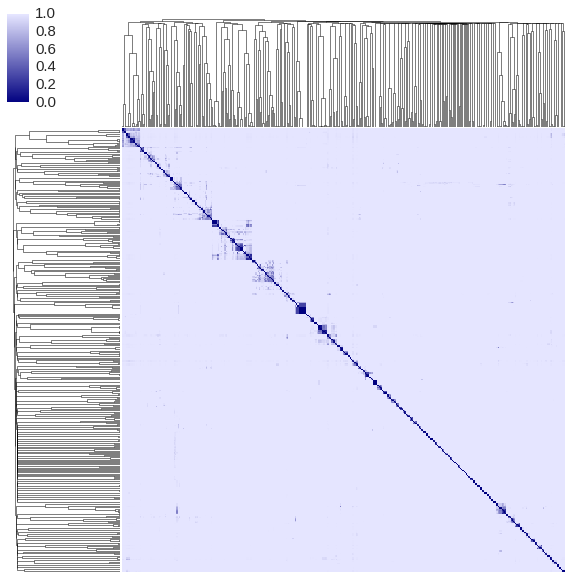

In [76]:
cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
g = sns.clustermap(data=log_dsim,
                   method='complete',
                   metric='correlation',
                   cmap=cmap,
                   xticklabels=False, yticklabels=False,
                   linewidths=0.0,
                   vmin=0.0,
                   vmax = 1.0)

In [8]:
# log_feature specific
a = '|'.join(['severity_type', 'event_type', 'resource_type', 'log_feature'])
c = df_all.filter(regex=a).copy()
all_corr = c.corr(min_periods=len(c.columns)/10)
all_dsim = 1.0 - np.abs(all_corr)

In [9]:
mask = np.ones(all_dsim.shape,dtype='bool')
mask[np.triu_indices(len(all_dsim))] = False
x = ((all_dsim < 0.03) & mask).values.nonzero()
a = zip(x[0], x[1])
for x, y in a:
    i1 = all_dsim.index[x]
    i2 = all_dsim.columns[y]
    if i1[:5] != i2[:5]:
        strongly_correlated.append((i1, i2))

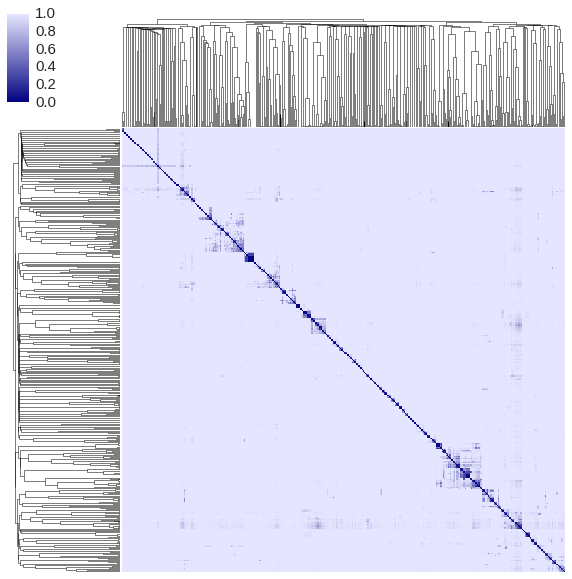

In [52]:
plt.figure(figsize=(22, 20))
cmap = sns.light_palette("navy", as_cmap=True, reverse=True)
g = sns.clustermap(data=all_dsim,
                   method='complete',
                   metric='correlation',
                   cmap=cmap,
                   xticklabels=False, yticklabels=False,
                   linewidths=0.0,
                   vmin=0.0,
                   vmax = 1.0)

In [10]:
print len(strongly_correlated)
strongly_correlated

121


[('severity_type_2', 'severity_type_1'),
 ('event_type_35', 'event_type_34'),
 ('event_type_44', 'event_type_42'),
 ('event_type_53', 'event_type_49'),
 ('log_feature_125', 'log_feature_120'),
 ('log_feature_131', 'log_feature_130'),
 ('log_feature_143', 'log_feature_142'),
 ('log_feature_147', 'log_feature_146'),
 ('log_feature_148', 'log_feature_146'),
 ('log_feature_148', 'log_feature_147'),
 ('log_feature_15', 'log_feature_149'),
 ('log_feature_16', 'log_feature_145'),
 ('log_feature_192', 'log_feature_175'),
 ('log_feature_2', 'log_feature_137'),
 ('log_feature_211', 'log_feature_160'),
 ('log_feature_213', 'log_feature_128'),
 ('log_feature_217', 'log_feature_132'),
 ('log_feature_219', 'log_feature_134'),
 ('log_feature_25', 'log_feature_111'),
 ('log_feature_27', 'log_feature_114'),
 ('log_feature_278', 'log_feature_277'),
 ('log_feature_28', 'log_feature_115'),
 ('log_feature_287', 'log_feature_286'),
 ('log_feature_29', 'log_feature_117'),
 ('log_feature_291', 'log_feature_28

The serverity types are mostly anti-correlated except type 1 and 2.

There is interesting structure in the resource and event types. Makes me more curious about how these events are networked, i.e. communicating to each other? Build out as network problem? Can't: id and loc are 1:1 so the only connections will be among events that are the same, in that they have the same coding across all types. I don't see that as informative to a model.

Log features are also clustered.

**But, this is clearly a well-defined classification problem.**

Want to see chains of correlations, e.g. [a,b]...[b,c], does that mean [a,c]? Run this...

In [17]:
# most common features in corr stack
sc_pairs = list(sum(strongly_correlated, ()))
Counter(sc_pairs).most_common(10)

[('log_feature_91', 5),
 ('log_feature_90', 5),
 ('log_feature_92', 5),
 ('log_feature_89', 5),
 ('log_feature_346', 5),
 ('log_feature_88', 5),
 ('log_feature_278', 3),
 ('event_type_52', 3),
 ('log_feature_277', 3),
 ('log_feature_372', 3)]

In [67]:
chains = []
for s in sorted(set(sum(strongly_correlated, ()))):
    tmp = []
    for sc in strongly_correlated:
        if s in sc:
            tmp.append(sc)
    
    chains.append(tuple(sorted(list(set(sum(tmp,()))))))

In [71]:
print 'Strong correlations: ', len(strongly_correlated)
print 'Resulting chains: ', len(set(chains))

Strong correlations:  121
Resulting chains:  85


In [ ]:
# for each chain
# create super feature
# find rows where all chain feature values == 1
# set super feature col == 1

a=['log_feature_160', 'log_feature_44']
df = df_train.copy()
df['super'] = np.zeros(len(df_train))
for c in a:
    df.super[(df[c] > 0)] = 1
    
d.sales[d.sales==24] = 100

## Averages

In [13]:
df = df_all[(df_all.is_train==True)].copy()

In [14]:
sorted(df.fault_severity.unique())

[0.0, 1.0, 2.0]

In [15]:
names = []
pers = []
avgs = []
stds = []
for a in attributes:
    cnt = len(a)
    for c in filter(lambda s: s[:cnt] == a, df.columns):
        d = df[(df[c]>0)]
        names.append(c)
        pers.append(100.*float(d.shape[0])/float(df.shape[0]))
        avgs.append(d.fault_severity.mean())
        stds.append(d.fault_severity.std())

In [16]:
fs = pd.DataFrame({'%tot':pers, 'avg':avgs, 'std':stds}, index=names).fillna(0)

In [17]:
fsv = [0, 1, 2]
cnt = 0
drop_cols = {}
for n in fsv:
    a = fs[(fs['avg']==n) & (fs['std']==0)]
    drop_cols[str(n)] = list(a.index)
    cnt += a.shape[0]
    print n, a.shape[0]
print "Drop ", cnt, " of ", fs.shape[0]
print "Keeping ", fs.shape[0]-cnt, " columns"

0 136
1 32
2 24
Drop  192  of  454
Keeping  262  columns


So there are 192 attributes with a set fault severity value and standard dev of zero. So what if I build a model for events where all those features are 0 with those features dropped. So the fitting logic then becomes:

```python
known_fs = {}
for fs, cols in drop_col.iteritems():
    for col in cols:
        for id in df[df[col] > 0]['id']:
            known_fs[id] = fs        
df = pd.get_dummies(known_fs)
```

## Uniqueness

### Event ID

In [3]:
# remove columns not characterizing events
cols = [c for c in df_all.columns if any(c[:5] in a for a in attributes)]
df = df_all[cols]

# ensure all are binary
df[(df != 0)] = 1

# convert binary strings to a 36-bit hashed md5 hex code for easier handling
df = df.apply(lambda x: int(hashlib.md5(''.join([e for e in x.astype(int).astype(str)])).hexdigest(), 36), axis=1)

# attach back
df_all['evt_id'] = df.astype(str)

# save group sizes
dsize = len(df_all)

### Event ID(Fault Severity)

In [4]:
# a stats handler for grouping
def get_stats(group):
    return {'evt_fs_sprd': group.max() - group.min(),
            'evt_cnt': len(group),
            'evt_freq': len(group)/float(dsize),
            'evt_fs_mean': group.mean(),
            'evt_fs_std': group.std()
           }

# build stats for each type of event
events = df_all['fault_severity'].\
            groupby(df_all['evt_id']).\
            apply(get_stats).\
            unstack().\
            sort_values(by='evt_freq', ascending=False).reset_index()

In [ ]:
events.drop('evt_id', 1).iplot(kind='histogram', barmode='stack', histnorm='percent')

In [7]:
# categorize the events based on freq
bins = [0, 0.00475, 0.009, 1]
group_names = ['rare', 'sparse', 'common']
events['evt_cat'] = pd.cut(events['evt_freq'], bins, labels=group_names)

In [87]:
events.iplot(kind='bubble', x='mean', y='freq', size='cnt',
             text='hexcode', categories='event_category',
             xTitle='Mean Fault Severity', yTitle='Type Frequency')

### Locations(Fault Severity)

In [5]:
# a stats handler for grouping
def get_stats(group):
    return {'loc_fs_sprd': group.max() - group.min(),
            'loc_cnt': len(group),
            'loc_freq': len(group)/float(dsize),
            'loc_fs_mean': group.mean(),
            'loc_fs_std': group.std()
           }

locations = df_all['fault_severity'].\
                groupby(df_all['location']).\
                apply(get_stats).\
                unstack().\
                sort_values(by='loc_freq', ascending=False).reset_index()

In [141]:
locations.drop('location', 1).iplot(kind='histogram', barmode='stack', histnorm='percent')

In [13]:
# categorize the events based on freq
bins = [0, 0.0013, 0.004, 1]
group_names = ['rare', 'sparse', 'common']
locations['loc_cat'] = pd.cut(locations['loc_freq'], bins, labels=group_names)

In [143]:
locations.iplot(kind='bubble', x='loc_fs_mean', y='loc_freq',
                size='loc_cnt', text='location', categories='location_category',
                xTitle='Mean Fault Severity', yTitle='Location Frequency')

## Culling

In [18]:
df_culled = df_all.copy()
for k, v in drop_cols.iteritems():
    for c in v:
        df_culled = df_culled[df_culled[c] == 0]
        df_culled.drop(c, 1, inplace=True)
print "Removed ", df_all.shape[0] - df_culled.shape[0], " rows"
print "Dropped ", df_all.shape[1] - df_culled.shape[1], " cols"

Removed  569  rows
Dropped  192  cols


In [20]:
hdf = pd.HDFStore(hdf_file)
hdf.put('df_culled', df_culled)
hdf.close()

In [21]:
known_fs = {}
for fs, cols in drop_cols.iteritems():
    for col in cols:
        for id in df_all[(df_all[col] > 0) & (df_all.is_train==False)]['id']:
            known_fs[id] = fs
df_known = pd.Series(known_fs, name='predict')
df_known.index.name = 'id'
df_known = pd.get_dummies(df_known, prefix='predict').reset_index()

In [22]:
df_known.head()

,id,predict_0,predict_1,predict_2
0,78,0,0,1
1,128,1,0,0
2,150,0,1,0
3,208,1,0,0
4,215,0,0,1


In [23]:
check = df_known['id'].head()
for a in check:
    print known_fs[a]

2
0
1
0
2


In [24]:
hdf = pd.HDFStore(hdf_file)
hdf.put('df_known', df_known)
hdf.close()

**NB: in the end, the shapes of culled+known = df_all**

In [25]:
assert df_known.shape[0] + df_culled[(df_culled.is_train==False)].shape[0] == df_all[(df_all.is_train==False)].shape[0], "this is wrong"

The known fault severity values are now stored in df_known in the hdf5, so let's predict the ones we don't know. K.I.S.S. == random forest. 

## Merge

In [6]:
train_merge = pd.read_csv('data/train_merge.csv')
test_merge = pd.read_csv('data/test_merge.csv')

In [7]:
# merge loc info and drop dupe cols
locations.location = locations.location.astype('int64')
a = pd.merge(train_merge, locations, how = 'left', left_on = 'numloc', right_on = 'location')
b = pd.merge(df_all[['id', 'evt_id']], events, how = 'left', left_on = 'evt_id', right_on = 'evt_id')
c = pd.merge(a, b, how = 'left', left_on = 'id', right_on = 'id')
c.drop(['loc_nid', 'numloc'], 1, inplace=True)
train_merge = c.copy()

In [8]:
a = pd.merge(test_merge, locations, how = 'left', left_on = 'numloc', right_on = 'location')
b = pd.merge(df_all[['id', 'evt_id']], events, how = 'left', left_on = 'evt_id', right_on = 'evt_id')
c = pd.merge(a, b, how = 'left', left_on = 'id', right_on = 'id')
c.drop(['loc_nid', 'numloc'], 1, inplace=True)
test_merge = c.copy()

In [93]:
# one hot encode
train_merge = pd.get_dummies(train_merge, columns=['loc_cat', 'evt_cat'])
test_merge = pd.get_dummies(test_merge, columns=['loc_cat', 'evt_cat'])

In [10]:
from sklearn.preprocessing import MinMaxScaler
train_merge.location = train_merge[['location']].apply(lambda x: MinMaxScaler().fit_transform(x))
test_merge.location = test_merge[['location']].apply(lambda x: MinMaxScaler().fit_transform(x))

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/usr/local/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning:

Data with input dtype int64 was converted to float64 by MinMaxScaler.

/usr/local/lib/python2.7/site-packages/s

In [11]:
train_merge.to_csv('data/train_master.csv', index=False)
test_merge.to_csv('data/test_master.csv', index=False)

# Scratch